In [ ]:
!pip install gym
!pip install matplotlib
!pip install torch


In [ ]:
!pip install gym
!pip install matplotlib
!pip install torch


In [ ]:
# Ensure PyTorch is imported
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)


cuda


Episode 0 | Reward: -73
Episode 5 | Reward: -26
Episode 10 | Reward: -17
Episode 15 | Reward: 18
Episode 20 | Reward: 39
Episode 25 | Reward: 40
Episode 30 | Reward: 40
Episode 35 | Reward: 40
Episode 40 | Reward: 40
Episode 45 | Reward: 40


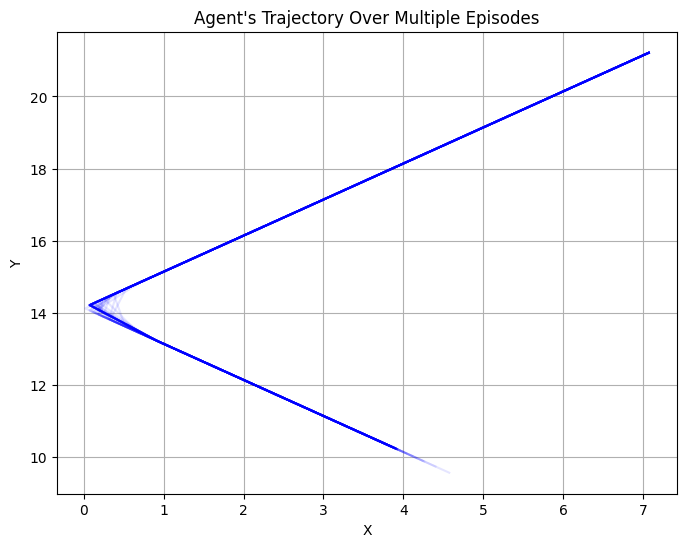

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import gym
from gym.spaces import Box


class CustomEnvironment(gym.Env):
    def __init__(self):
        super(CustomEnvironment, self).__init__()
        self.obstacles = [
            ("macro", 5, 5),
            ("macro", 15, 15),
            ("micro", 7, 7),
            ("micro", 12, 8)
        ]

        self.action_space = Box(
            low=np.array([-1.0, 0.0]),
            high=np.array([1.0, 1.0]),
            dtype=np.float32
        )

        self.observation_space = Box(
            low=-np.inf,
            high=np.inf,
            shape=(len(self.obstacles) + 4,),
            dtype=np.float32
        )

        self.max_steering_angle = np.pi / 4
        self.bounds = np.array([[-10, -10], [10, 10]])
        self.reset()

    def reset(self):
        self.state = np.array([0.0, 0.0, 0.0])
        self.goal = np.array([8.0, 8.0])
        return self._get_observation()

    def _get_observation(self):
        distances = [
            np.linalg.norm(self.state[:2] - np.array([obs_x, obs_y]))
            for _, obs_x, obs_y in self.obstacles
        ]
        goal_direction = self.goal - self.state[:2]
        goal_distance = np.linalg.norm(goal_direction)
        steering_angle = self.state[2]
        return np.concatenate([distances, goal_direction, [goal_distance, steering_angle]])

    def step(self, action):
        steering_angle_change, speed = action
        self.state[2] += steering_angle_change
        self.state[2] = np.clip(self.state[2], -self.max_steering_angle, self.max_steering_angle)
        dx = speed * np.cos(self.state[2])
        dy = speed * np.sin(self.state[2])
        self.state[:2] += [dx, dy]
        self.state[:2] = np.clip(self.state[:2], self.bounds[0], self.bounds[1])

        reward = -1
        done = False

        if np.linalg.norm(self.state[:2] - self.goal) < 0.5:
            reward = 100
            done = True

        for obs_type, obs_x, obs_y in self.obstacles:
            dist = np.linalg.norm(self.state[:2] - np.array([obs_x, obs_y]))
            if dist < 1.0:
                reward -= 20 if obs_type == "macro" else 5

        return self._get_observation(), reward, done, {}

    def render(self, path=None):
        plt.figure()
        macro_obstacles = [obs[1:] for obs in self.obstacles if obs[0] == "macro"]
        micro_obstacles = [obs[1:] for obs in self.obstacles if obs[0] == "micro"]
        plt.scatter(*zip(*macro_obstacles), color="red", label="Macro Obstacles")
        plt.scatter(*zip(*micro_obstacles), color="orange", label="Micro Obstacles")
        plt.scatter(*self.goal, color="green", label="Goal", s=100)
        plt.scatter(0, 0, color="blue", label="Start", s=100)

        if path:
            plt.plot(*zip(*path), color="blue", label="Path")

        plt.legend()
        plt.xlim(self.bounds[0][0], self.bounds[1][0])
        plt.ylim(self.bounds[0][1], self.bounds[1][1])
        plt.title("Agent's Path and Obstacles")
        plt.xlabel("X")
        plt.ylabel("Y")
        plt.grid()
        plt.show()


class PPOAgent(nn.Module):
    def __init__(self, input_dim, action_dim):
        super(PPOAgent, self).__init__()
        self.fc1 = nn.Linear(input_dim, 32)  # Reduced neurons for simplicity
        self.fc2 = nn.Linear(32, 16)
        self.policy_head = nn.Linear(16, action_dim)
        self.value_head = nn.Linear(16, 1)

    def forward(self, state):
        x = torch.relu(self.fc1(state))
        x = torch.relu(self.fc2(x))
        policy = self.policy_head(x)
        value = self.value_head(x)
        return policy, value


def train():
    env = CustomEnvironment()
    input_dim = len(env.obstacles) + 4
    action_dim = 2
    agent = PPOAgent(input_dim=input_dim, action_dim=action_dim)
    optimizer = optim.Adam(agent.parameters(), lr=0.001)

    gamma = 0.99
    epochs = 5  # Reduced epochs
    batch_size = 16  # Smaller batch size for faster training

    rewards_log = []
    all_paths = []

    for episode in range(50):  # Reduced episodes
        state = env.reset()
        done = False
        episode_reward = 0
        states, actions, rewards = [], [], []
        path = [(state[0], state[1])]

        while not done:
            state_tensor = torch.FloatTensor(state).unsqueeze(0)
            policy, _ = agent(state_tensor)
            action = torch.tanh(policy).detach().numpy()[0]
            next_state, reward, done, _ = env.step(action)

            path.append((next_state[0], next_state[1]))

            states.append(state)
            actions.append(action)
            rewards.append(reward)

            state = next_state
            episode_reward += reward

        # Simplified advantage computation
        returns = [sum(rewards[i:] * (gamma ** np.arange(len(rewards[i:])))) for i in range(len(rewards))]

        for _ in range(epochs):
            for i in range(0, len(states), batch_size):
                batch_states = torch.FloatTensor(states[i:i + batch_size])
                batch_actions = torch.FloatTensor(actions[i:i + batch_size])
                batch_returns = torch.FloatTensor(returns[i:i + batch_size])

                policy, value = agent(batch_states)
                loss = ((batch_returns - value.squeeze()) ** 2).mean()  # Simple value loss
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

        rewards_log.append(episode_reward)
        if episode % 5 == 0:  # Print every 5 episodes
            print(f"Episode {episode} | Reward: {episode_reward}")

        all_paths.append(path)

    plt.figure(figsize=(8, 6))
    for path in all_paths:
        plt.plot(*zip(*path), color='blue', alpha=0.1)
    plt.title("Agent's Trajectory Over Multiple Episodes")
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.grid(True)
    plt.show()


train()


Episode 0, Reward: -574
Episode 1, Reward: -3890
Episode 2, Reward: -2058
Episode 3, Reward: -5454
Episode 4, Reward: -4769
Episode 5, Reward: -196
Episode 6, Reward: -4422
Episode 7, Reward: -10630
Episode 8, Reward: -4585
Episode 9, Reward: -4209
Episode 10, Reward: -584
Episode 11, Reward: -12535
Episode 12, Reward: -4240
Episode 13, Reward: -9653
Episode 14, Reward: -284
Episode 15, Reward: -4413
Episode 16, Reward: -1430
Episode 17, Reward: -17973
Episode 18, Reward: -5425
Episode 19, Reward: -5777
Episode 20, Reward: -6322
Episode 21, Reward: -4048
Episode 22, Reward: -1480
Episode 23, Reward: -2140
Episode 24, Reward: -427
Episode 25, Reward: -7284
Episode 26, Reward: -3015
Episode 27, Reward: -11275
Episode 28, Reward: -1520
Episode 29, Reward: -15395
Episode 30, Reward: -3542
Episode 31, Reward: -853
Episode 32, Reward: -2245
Episode 33, Reward: -2144
Episode 34, Reward: -264
Episode 35, Reward: -3394
Episode 36, Reward: -4005
Episode 37, Reward: -5177
Episode 38, Reward: -879

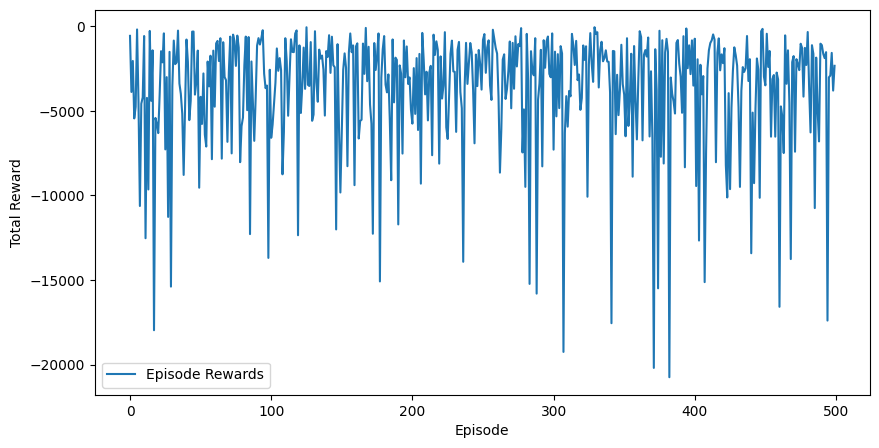

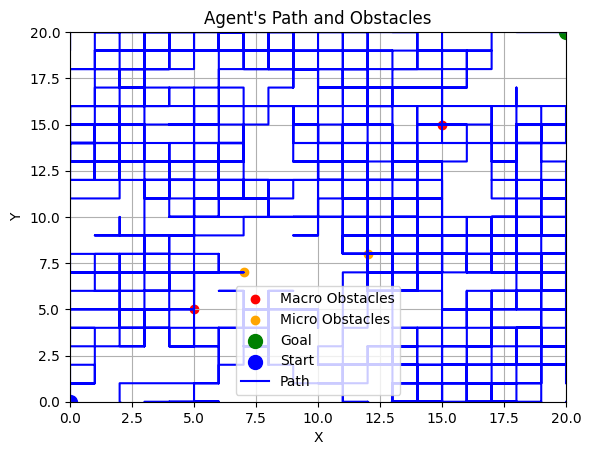

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim

# Custom Environment
class CustomEnvironment:
    def __init__(self):
        self.state = np.array([0.0, 0.0])
        self.goal = np.array([20.0, 20.0])  # Goal Position
        # Define obstacles as (type, x, y)
        self.obstacles = [
            ("macro", 5.0, 5.0),
            ("macro", 15.0, 15.0),
            ("micro", 7.0, 7.0),
            ("micro", 12.0, 8.0),
        ]
        self.action_space = 4  # 4 possible actions (Up, Down, Left, Right)
        self.bounds = [0, 20]  # State bounds for x and y

    def reset(self):
        self.state = np.array([0.0, 0.0])  # Reset agent to start position
        return self.state

    def step(self, action):
        reward = -1  # Small step penalty to encourage efficient paths
        if action == 0:  # Move up
            self.state[1] += 1
        elif action == 1:  # Move down
            self.state[1] -= 1
        elif action == 2:  # Move right
            self.state[0] += 1
        elif action == 3:  # Move left
            self.state[0] -= 1

        # Ensure state is within bounds
        self.state = np.clip(self.state, self.bounds[0], self.bounds[1])

        # Reward for reaching the goal
        if np.linalg.norm(self.state - self.goal) < 0.5:
            reward = 100
            done = True
        else:
            done = False

        # Penalize for proximity to obstacles
        for obs_type, obs_x, obs_y in self.obstacles:
            dist = np.linalg.norm(self.state - np.array([obs_x, obs_y]))
            if dist < 1.0:  # Proximity threshold
                if obs_type == "macro":
                    reward -= 20  # High penalty for macro obstacles
                elif obs_type == "micro":
                    reward -= 5   # Lower penalty for micro obstacles

        return self.state, reward, done, {}

    def render(self, path=None):
        plt.figure()
        macro_obstacles = [obs[1:] for obs in self.obstacles if obs[0] == "macro"]
        micro_obstacles = [obs[1:] for obs in self.obstacles if obs[0] == "micro"]

        plt.scatter(*zip(*macro_obstacles), color="red", label="Macro Obstacles")
        plt.scatter(*zip(*micro_obstacles), color="orange", label="Micro Obstacles")
        plt.scatter(*self.goal, color="green", label="Goal", s=100)
        plt.scatter(0, 0, color="blue", label="Start", s=100)

        if path:
            plt.plot(*zip(*path), color="blue", label="Path")
        plt.legend()
        plt.xlim(self.bounds)
        plt.ylim(self.bounds)
        plt.title("Agent's Path and Obstacles")
        plt.xlabel("X")
        plt.ylabel("Y")
        plt.grid()
        plt.show()

# PPO Components
class PPOAgent(nn.Module):
    def __init__(self, input_dim, action_dim):
        super(PPOAgent, self).__init__()
        self.fc1 = nn.Linear(input_dim, 128)
        self.fc2 = nn.Linear(128, 128)
        self.policy_head = nn.Linear(128, action_dim)
        self.value_head = nn.Linear(128, 1)

    def forward(self, state):
        x = torch.relu(self.fc1(state))
        x = torch.relu(self.fc2(x))
        policy = self.policy_head(x)
        value = self.value_head(x)
        return policy, value

def compute_gae(rewards, values, dones, gamma, gae_lambda):
    advantages = []
    gae = 0
    for step in reversed(range(len(rewards))):
        delta = rewards[step] + (1 - dones[step]) * gamma * values[step + 1] - values[step]
        gae = delta + (1 - dones[step]) * gamma * gae_lambda * gae
        advantages.insert(0, gae)
    return advantages

# Training PPO
def train():
    env = CustomEnvironment()
    agent = PPOAgent(input_dim=2, action_dim=4)
    optimizer = optim.Adam(agent.parameters(), lr=0.001)

    gamma = 0.99
    gae_lambda = 0.95
    clip_epsilon = 0.2
    epochs = 10
    batch_size = 32

    # Logging
    rewards_log, loss_log = [], []
    paths = []

    for episode in range(500):
        state = env.reset()
        done = False
        episode_reward = 0
        states, actions, rewards, dones, values = [], [], [], [], []

        # Rollout
        while not done:
            state_tensor = torch.FloatTensor(state).unsqueeze(0)
            policy, value = agent(state_tensor)

            # Prevent NaN or Inf in probabilities by ensuring numerical stability
            action_probs = torch.softmax(policy, dim=-1)
            if torch.any(torch.isnan(action_probs)) or torch.any(torch.isinf(action_probs)):
                action = np.random.choice(4)  # Fall back to random action if probs are invalid
            else:
                action = torch.multinomial(action_probs, 1).item()

            next_state, reward, done, _ = env.step(action)
            episode_reward += reward

            # Logging trajectory
            states.append(state)
            actions.append(action)
            rewards.append(reward)
            dones.append(done)
            values.append(value.item())

            state = next_state

        values.append(agent(torch.FloatTensor(state).unsqueeze(0))[1].item())
        advantages = compute_gae(rewards, values, dones, gamma, gae_lambda)
        targets = [r + gamma * v for r, v in zip(rewards, values)]

        # PPO Updates
        for _ in range(epochs):
            for i in range(0, len(states), batch_size):
                batch_states = torch.FloatTensor(states[i:i + batch_size])
                batch_actions = torch.LongTensor(actions[i:i + batch_size])
                batch_advantages = torch.FloatTensor(advantages[i:i + batch_size])
                batch_targets = torch.FloatTensor(targets[i:i + batch_size])

                policy, value = agent(batch_states)
                action_probs = torch.softmax(policy, dim=-1).gather(1, batch_actions.unsqueeze(1)).squeeze()
                old_action_probs = action_probs.detach()
                ratios = action_probs / old_action_probs

                policy_loss = -torch.mean(torch.min(
                    ratios * batch_advantages,
                    torch.clamp(ratios, 1 - clip_epsilon, 1 + clip_epsilon) * batch_advantages
                ))
                value_loss = torch.mean((batch_targets - value.squeeze()) ** 2)

                loss = policy_loss + 0.5 * value_loss
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

        # Log results
        rewards_log.append(episode_reward)
        if episode % 1 == 0:
            paths.append(states)
            print(f"Episode {episode}, Reward: {episode_reward}")

    # Plot results
    plt.figure(figsize=(10, 5))
    plt.plot(rewards_log, label="Episode Rewards")
    plt.xlabel("Episode")
    plt.ylabel("Total Reward")
    plt.legend()
    plt.show()

    env.render(path=paths[-1])  # Show final path

if __name__ == "__main__":
    train()
